# VCGC: Vertex Coloring with Grover's Circuit - G001 Partitioned
Rudimentary Curcuit To Run Grover's Search Algorithm for a vertex coloring instance on the AER simulator and IBM's Quantum Computer. 

![G000_PARTITIONED](../data/networkx/g001_partitioned.png)

### 1. Prepare the circuit and add the uniform state preparation operator. 

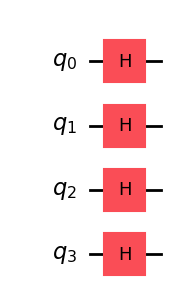

In [78]:
from qiskit import *

num_qubits = 4
# Subcircuit for uniform state preparation operator
state_prep_oracle= QuantumCircuit(num_qubits,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(num_qubits):
    state_prep_oracle.h(qubit)

# qc.decompose(gates_to_decompose="state_prep").draw('mpl')
state_prep_oracle.draw('mpl')

### 2. Using Tweedledum to convert the predicate function to quantum circuit

In [79]:
# Create a quantum subcircuit for grover oracle
from tweedledum.synthesis import xag_synth  # Import XAG synthesis
from qiskit.circuit.classicalfunction.utils import tweedledum2qiskit
from qiskit.circuit.classicalfunction import ClassicalFunction
from tweedledum.qiskit import *
from qiskit.circuit.classicalfunction.types import Int1
from tweedledum.bool_function_compiler.bitvec import BitVec
from tweedledum.bool_function_compiler.bool_function import BoolFunction

def xag_synthesizer(cf):
    """Custom synthesizer using XAG synthesis instead of PKRM""" 

    # Get the LogicNetwork object from cf.network
    logic_network = cf._logic_network
    
    # Perform XAG synthesis ONCE and store the result
    tweedledum_circuit = xag_synth(logic_network)
    print(f"Number of qubits in Tweedledum circuit: {tweedledum_circuit.num_qubits()}")
    print(tweedledum_circuit)
    qc_qiskit = to_qiskit(tweedledum_circuit, circuit_type="gatelist")

    return qc_qiskit

#### Partition 1 Grover Oracle

Number of qubits in Tweedledum circuit: 3
            ╭───╮     
__q2 : ─────┤ x ├─────
       ╭───╮╰─┬─╯╭───╮
__q1 : ┤ x ├──●──┤ x ├
       ╰─┬─╯  │  ╰─┬─╯
__q0 : ──●────●────●──
                      

<class 'qiskit.circuit.library.standard_gates.x.XGate'>
<class 'qiskit.circuit.library.standard_gates.x.XGate'>
<class 'qiskit.circuit.library.standard_gates.x.XGate'>
Circuit Depth: 3


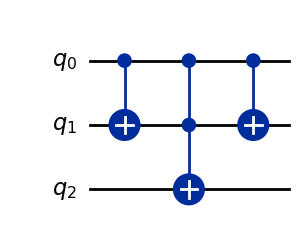

In [80]:

def grover_oracle_func1(v0: BitVec(1), v5: BitVec(1)) -> BitVec(1):
    
    return (v0 != BitVec(1, 0) ) and v0 != v5

bf1 = BoolFunction(grover_oracle_func1)
grover_oracle_1 = xag_synthesizer(bf1)
grover_oracle_1.name = "grover_oracle_func1"
print("Circuit Depth: " + str(grover_oracle_1.depth()))
grover_oracle_1.draw('mpl')

#### Partition 2 Grover Oracle

Number of qubits in Tweedledum circuit: 3
            ╭───╮     
__q2 : ─────┤ x ├─────
       ╭───╮╰─┬─╯╭───╮
__q1 : ┤ x ├──●──┤ x ├
       ╰─┬─╯  │  ╰─┬─╯
__q0 : ──●────◯────●──
                      

<class 'qiskit.circuit.library.standard_gates.x.XGate'>
<class 'qiskit.circuit.library.standard_gates.x.XGate'>
<class 'qiskit.circuit.library.standard_gates.x.XGate'>
Circuit Depth: 3


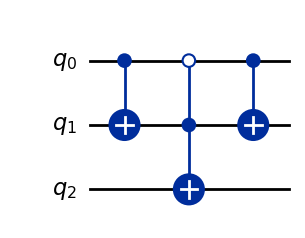

In [81]:
def grover_oracle_func2(v3: BitVec(1), v4: BitVec(1)) -> BitVec(1):
    
    return (v3 != BitVec(1, 1) ) and v3 != v4

bf2 = BoolFunction(grover_oracle_func2)
grover_oracle_2 = xag_synthesizer(bf2)
grover_oracle_2.name = "grover_oracle_func2"
print("Circuit Depth: " + str(grover_oracle_2.depth()))
grover_oracle_2.draw('mpl')

Determining the number of qubits needed

In [93]:
num_qubits_oracle = grover_oracle_1.num_qubits + grover_oracle_2.num_qubits -1
num_qubits_oracle

5

### 3. Defining the diffusion operator

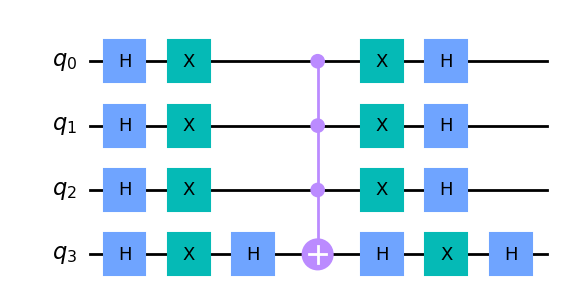

In [94]:
# Create a quantum subcircuit for grover diffusion operator
def create_grover_diffusion_operator(num_qubits):
    # Create a quantum subcircuit for grover diffusion operator
    grover_diff = QuantumCircuit(num_qubits, name="grover_diffusion")
    grover_diff.h(range(num_qubits))
    grover_diff.x(range(num_qubits))
    grover_diff.h(num_qubits - 1)
    grover_diff.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    grover_diff.h(num_qubits - 1)
    grover_diff.x(range(num_qubits))
    grover_diff.h(range(num_qubits))
    return grover_diff

grover_diffusion = create_grover_diffusion_operator(num_qubits)

grover_diffusion.draw('mpl',style='clifford')

### 4. Connect the whole circuit together

In [101]:
# Combining the subcircuits to form the complete Grover's algorithm

qc = QuantumCircuit(num_qubits_oracle, num_qubits_oracle)
qc.barrier()
qc.x(num_qubits_oracle-1)
qc.h(num_qubits_oracle-1)
# qc.x(num_qubits_oracle-2)
# qc.h(num_qubits_oracle-2)
qc.append(state_prep_oracle, list(range(num_qubits)))
qc.barrier()
qc.append(grover_oracle_1, [0,3,4])
qc.x(4)
qc.append(grover_oracle_2, [1,2,4])
qc.barrier()
qc.append(grover_diffusion,  list(range(num_qubits)))
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4)), clbits=())

#### Drawing the Circuit

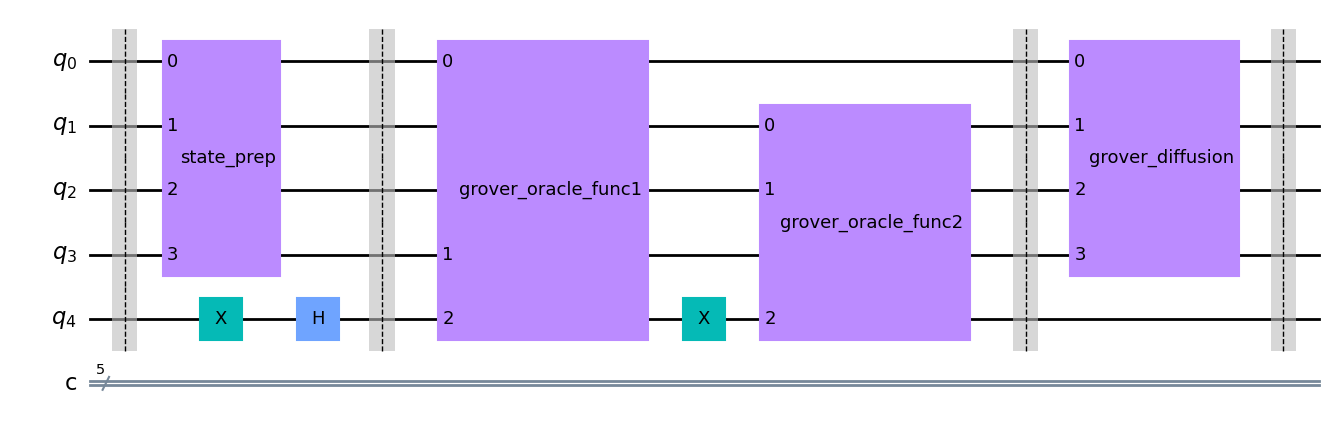

In [102]:

qc.draw('mpl', style='clifford')

### 5. Add measurements and decompose the circuits for the AER simulator

#### Regular Circuit

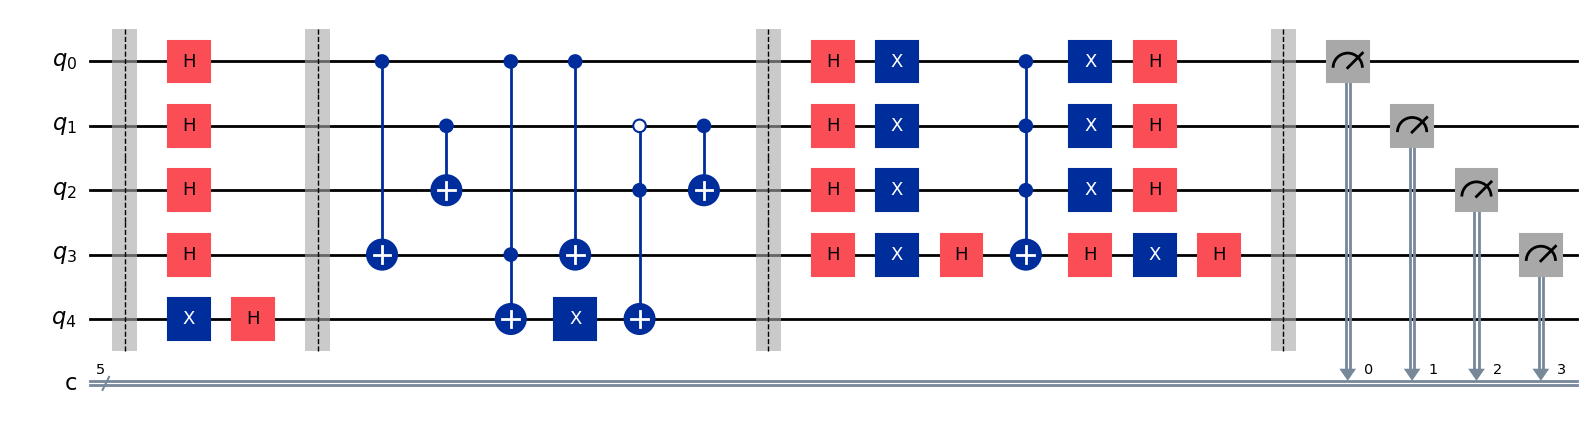

In [103]:
# qc_regular.measure_all(add_bits=False)
qc.measure(list(range(num_qubits)), list(range(num_qubits))) # Measure the first 3 qubits
qc_decomposed : QuantumCircuit = qc.decompose(gates_to_decompose=["state_prep", "grover_oracle_func1", "grover_oracle_func2", "grover_diffusion"])
qc_decomposed.draw('mpl')


### 6. Run the circuits in the AER Simulator

##### Prepare the AER Simulator

In [104]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit import transpile
# Creating the backend
qasm_sim = Aer.get_backend('aer_simulator')

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

#### Partitioned Circuit

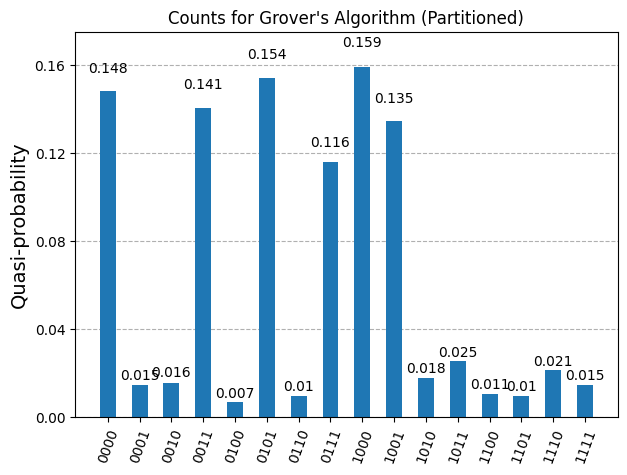

In [105]:
# qc_decomposed_transpiled = transpile(qc_decomposed, backend=qasm_sim)
result = qasm_sim.run(qc_decomposed).result()
counts= result.get_counts()
counts_processed = process_counts(counts, num_qubits=num_qubits)

plot_distribution(counts_processed, title="Counts for Grover's Algorithm (Partitioned)")

### 7. Preparing Real IBM Quantum Device Backends

#### Getting a chosen backend and the least busy backend

In [67]:

# Run our circuit on the least busy backend. Transpiling before running.
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

least_busy_backend = service.least_busy(simulator=False, operational=True)
pick_backend = service.backend("ibm_brisbane")

least_busy_target = least_busy_backend.target
pick_target = pick_backend.target
print(f"Least busy backend: {least_busy_backend.name}")
print(f"The other backend: {pick_backend.name}")

Least busy backend: ibm_brisbane
The other backend: ibm_brisbane


#### Dynamic Decoupling Circuit (JB's code)
This code snippet demonstrates the use of dynamic decoupling to mitigate decoherence in quantum circuits. The `PassManager` is configured with the `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` passes to apply dynamic decoupling sequences to the circuit. The optimized circuits are then transpiled and their depths are printed.

In [68]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations

durations = DynamicCircuitInstructionDurations.from_backend(backend=least_busy_backend)
 
optimized_pm = generate_preset_pass_manager(target=least_busy_target, optimization_level=3)
dd_rep = 8
dd_sequence = [XGate()] * dd_rep

optimized_pm.scheduling = PassManager([
    ALAPScheduleAnalysis(durations=durations),
    PadDynamicalDecoupling(
        durations=durations,
        dd_sequences=dd_sequence,
        pulse_alignment=16
    )
])

NUM_TRIAL = 10
transpiled_circuits = []
for i in range(NUM_TRIAL):
    transpiled_circuits.append(optimized_pm.run(qc))
    


depths = [circuit.depth() for circuit in transpiled_circuits]
print("Circuit Depths:")
print(depths)


Circuit Depths:
[161, 178, 152, 169, 152, 165, 161, 178, 161, 174]


In [69]:

print("Circuits Qubits:")
for circuit in transpiled_circuits:
    print(circuit.layout.final_index_layout())


Circuits Qubits:
[57, 58, 59, 56, 71]
[57, 58, 59, 52, 71]
[58, 59, 57, 56, 71]
[58, 59, 57, 52, 71]
[58, 59, 57, 56, 71]
[58, 59, 57, 56, 71]
[57, 58, 59, 56, 71]
[57, 58, 59, 52, 71]
[57, 58, 59, 56, 71]
[57, 58, 59, 56, 71]


In [70]:
transpiled_circuit = transpiled_circuits[0]
# used_qubits = regular_transpiled_circuit.layout.final_index_layout()
used_qubits = transpiled_circuit.layout.final_index_layout()
print("Used Qubit for the Inverted Circuit: " + str(used_qubits))

Used Qubit for the Inverted Circuit: [57, 58, 59, 56, 71]


In [71]:
print(type(transpiled_circuit.layout.final_index_layout()))
print(used_qubits)

<class 'list'>
[57, 58, 59, 56, 71]


### 8. Run the circuits in the least busy backend

#### Calibration Job

In [72]:
import mthree
mit = mthree.M3Mitigation(least_busy_backend)
mit.cals_from_system(used_qubits)

/home/mael/Desktop/vcgc/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:863: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


[<RunningManJob('d1e3gxv3grvg008n6wxg', backend='ibm_brisbane', mode_id=None)>]

#### Running the circuits

In [73]:
# Running the transpiled circuits using the sampler
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=least_busy_backend)
sampler.options.default_shots = 10_000
job = sampler.run([transpiled_circuit])

### $\color{yellow}{\text{9. Plot the results }}$

In [74]:
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=10000, num_bits=5>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-06-25 17:57:51', stop='2025-06-25 17:57:55', size=10000>)])}, 'version': 2})

#### Partitioned Circuit

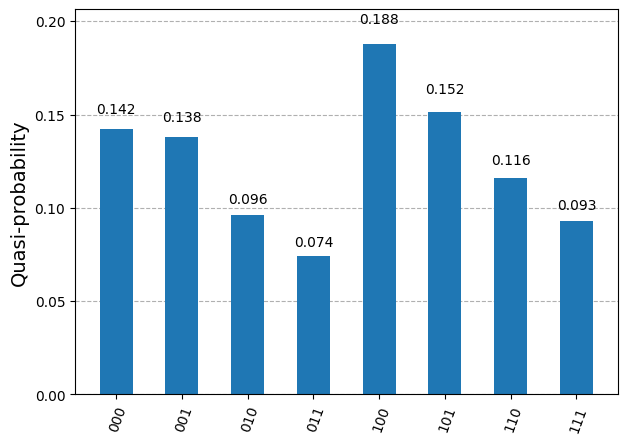

In [75]:
from qiskit.visualization import plot_distribution
result = job.result()
raw_counts = result[0].data.c.get_counts()
counts = process_counts(raw_counts, num_qubits=num_qubits)
plot_distribution(counts)

### $\color{orange}{\text{10. M3 Mitigation Correction}}$

#### Regular Circuit

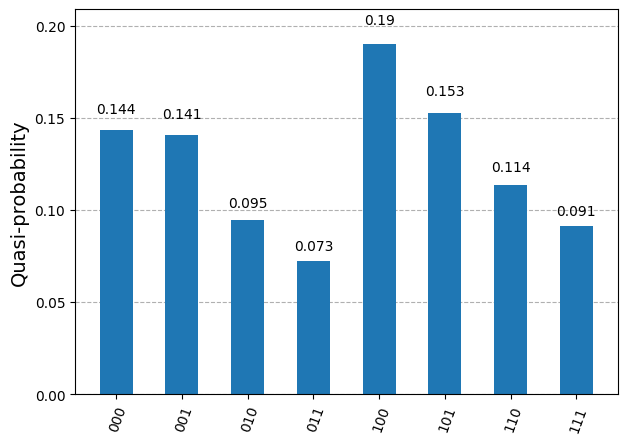

In [77]:
reg_quasi = mit.apply_correction(raw_counts, used_qubits)

mitigated_counts = {k: int(v*10_000) for k, v in reg_quasi.items()}

plot_distribution(process_counts(mitigated_counts, num_qubits))